#### 搜索引擎

搜集：
利用爬虫爬取网页


分析：
主要负责网页内容抽取、分词，构建临时索引，计算 PageRank 值这几部分工作

索引：
主要负责通过分析阶段得到的临时索引，构建倒排索引

查询：
主要负责响应用户的请求，根据倒排索引获取相关网页，计算网页排名，返回查询结果给用户


#### 搜索

搜索引擎把整个互联网看作数据结构中的有向图
* 把每个页面看作一个顶点
* 如果某个页面中包含另外一个页面的链接，那就在两个顶点之间连一条有向边
* 可以利用图的遍历搜索算法，来遍历整个互联网中的网页
* 搜索引擎采用的是广度优先搜索策略。
  * 先找一些比较知名的网页（专业的叫法是权重比较高）的链接（比如新浪主页网址、腾讯主页网址等），作为种子网页链接，放入到队列中。
  * 爬虫按照广度优先的策略，不停地从队列中取出链接，然后去爬取对应的网页，解析出网页里包含的其他网页链接，再将解析出来的链接添加到队列中。

爬虫在爬取网页的过程中，涉及的四个重要的文件
* links.bin 和 bloom_filter.bin 这两个文件是爬虫自身所用的
* 另外的两个（doc_raw.bin、doc_id.bin）是作为搜集阶段的成果，供后面的分析、索引、查询用的。

实现：
1. 待爬取网页链接文件：links.bin
   1. 在广度优先搜索爬取页面的过程中，爬虫会不停地解析页面链接，将其放到队列中。于是，队列中的链接就会越来越多，可能会多到内存放不下。所以，用一个存储在磁盘中的文件（links.bin）来作为广度优先搜索中的队列。爬虫从 links.bin 文件中，取出链接去爬取对应的页面。等爬取到网页之后，将解析出来的链接，直接存储到 links.bin 文件中。
   2. 这样用文件来存储网页链接的方式，还有其他好处。比如，支持断点续爬。也就是说，当机器断电之后，网页链接不会丢失；当机器重启之后，还可以从之前爬取到的位置继续爬取。
   3. 关于如何解析页面获取链接，可以把整个页面看作一个大的字符串，然后利用字符串匹配算法，在这个大字符串中，搜索这样一个网页标签，然后顺序读取之间的字符串。这其实就是网页链接。
2. 网页判重文件：bloom_filter.bin
   1. 使用布隆过滤器，我们就可以快速并且非常节省内存地实现网页的判重。
   2. 如果把布隆过滤器存储在内存中，那机器宕机重启之后，布隆过滤器就被清空了。这样就可能导致大量已经爬取的网页会被重复爬取。
   3. 定期地（比如每隔半小时）将布隆过滤器持久化到磁盘中，存储在 bloom_filter.bin 文件中。这样，即便出现机器宕机，也只会丢失布隆过滤器中的部分数据。当机器重启之后，可以重新读取磁盘中的 bloom_filter.bin 文件，将其恢复到内存中。
3. 原始网页存储文件：doc_raw.bin
   1. 爬取到网页之后，我们需要将其存储下来，以备后面离线分析、索引之用。那如何存储海量的原始网页数据呢？
   2. 如果我们把每个网页都存储为一个独立的文件，那磁盘中的文件就会非常多，数量可能会有几千万，甚至上亿。常用的文件系统显然不适合存储如此多的文件。所以，我们可以把多个网页存储在一个文件中。每个网页之间，通过一定的标识进行分隔，方便后续读取。具体的存储格式，如下图所示
   3. 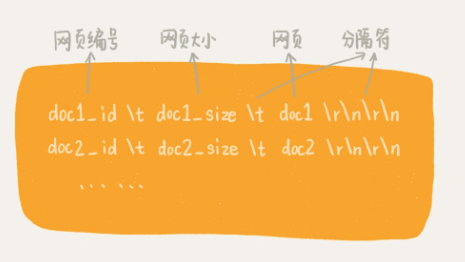
   4. 这样的一个文件也不能太大，因为文件系统对文件的大小也有一定的限制。所以，我们可以设置每个文件的大小不能超过一定的值（比如 1GB）。随着越来越多的网页被添加到文件中，文件的大小就会越来越大，当超过 1GB 的时候，我们就创建一个新的文件，用来存储新爬取的网页。
   5. 假设一台机器的硬盘大小是 100GB 左右，一个网页的平均大小是 64KB。那在一台机器上，我们可以存储 100 万到 200 万左右的网页。假设我们的机器的带宽是 10MB，那下载 100GB 的网页，大约需要 10000 秒。也就是说，爬取 100 多万的网页，也就是只需要花费几小时的时间。
4. 网页链接及其编号的对应文件：doc_id.bin
   1. 提到了网页编号这个概念，我现在解释一下。网页编号实际上就是给每个网页分配一个唯一的 ID，方便我们后续对网页进行分析、索引
   2. 我们可以按照网页被爬取的先后顺序，从小到大依次编号。具体是这样做的：我们维护一个中心的计数器，每爬取到一个网页之后，就从计数器中拿一个号码，分配给这个网页，然后计数器加一。在存储网页的同时，我们将网页链接跟编号之间的对应关系，存储在另一个 doc_id.bin 文件中。



#### 分析

网页爬取下来之后，我们需要对网页进行离线分析。分析阶段主要包括两个步骤，第一个是抽取网页文本信息，第二个是分词并创建临时索引

##### 抽取网页文本信息

* 网页是半结构化数据，里面夹杂着各种标签、JavaScript 代码、CSS 样式。对于搜索引擎来说，它只关心网页中的文本信息，也就是，网页显示在浏览器中时，能被用户肉眼看到的那部分信息
* 我们之所以把网页叫作半结构化数据，是因为它本身是按照一定的规则来书写的。这个规则就是 HTML 语法规范。我们依靠 HTML 标签来抽取网页中的文本信息。这个抽取的过程，大体可以分为两步。
* 第一步是去掉 JavaScript 代码、CSS 格式以及下拉框中的内容（因为下拉框在用户不操作的情况下，也是看不到的）。也就是，，这三组标签之间的内容。我们可以利用 AC 自动机这种多模式串匹配算法，在网页这个大字符串中，一次性查找, ,
* 第二步是去掉所有 HTML 标签。这一步也是通过字符串匹配算法来实现的。过程跟第一步类似，我就不重复讲了。

##### 分词并创建临时索引

经过分析阶段，我们得到了两个重要的文件。它们分别是临时索引文件（tmp_index.bin）和单词编号文件（term_id.bin）

`基于字典和规则的分词方法`
* 字典也叫词库，里面包含大量常用的词语（可以直接从网上下载别人整理好的）。借助词库并采用最长匹配规则，来对文本进行分词。所谓最长匹配，也就是匹配尽可能长的词语
  * 比如要分词的文本是“中国人民解放了”，我们词库中有“中国”“中国人”“中国人民”“中国人民解放军”这几个词，那我们就取最长匹配，也就是“中国人民”划为一个词，而不是把“中国”、“中国人”划为一个词。具体到实现层面，我们可以将词库中的单词，构建成 Trie 树结构，然后拿网页文本在 Trie 树中匹配。
* 每个网页的文本信息在分词完成之后，我们都得到一组单词列表。我们把单词与网页之间的对应关系，写入到一个临时索引文件中（tmp_Index.bin），这个临时索引文件用来构建倒排索引文件。临时索引文件的格式如下：
  * 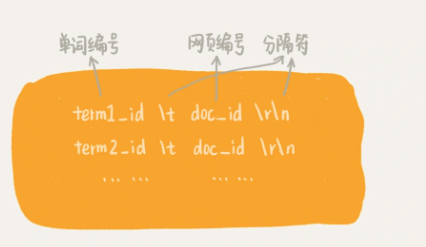
* 在临时索引文件中，我们存储的是单词编号，也就是图中的 term_id，而非单词本身。这样做的目的主要是为了节省存储的空间
* 给单词编号的方式，跟给网页编号类似。我们维护一个计数器，每当从网页文本信息中分割出一个新的单词的时候，我们就从计数器中取一个编号，分配给它，然后计数器加一
* 在这个过程中，我们还需要使用散列表，记录已经编过号的单词。在对网页文本信息分词的过程中，我们拿分割出来的单词，先到散列表中查找，如果找到，那就直接使用已有的编号；如果没有找到，我们再去计数器中拿号码，并且将这个新单词以及编号添加到散列表中
* 当所有的网页处理（分词及写入临时索引）完成之后，我们再将这个单词跟编号之间的对应关系，写入到磁盘文件中，并命名为 term_id.bin。




#### 索引

经过索引阶段的处理，得到了两个有价值的文件，它们分别是倒排索引文件（index.bin）和记录单词编号在索引文件中的偏移位置的文件（term_offset.bin）。

索引阶段主要负责将分析阶段产生的临时索引，构建成倒排索引。倒排索引（ Inverted index）中记录了每个单词以及包含它的网页列表
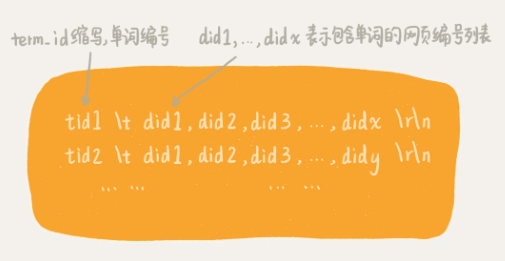

* 考虑到临时索引文件很大，无法一次性加载到内存中，搜索引擎一般会选择使用多路归并排序的方法来实现。
* 先对临时索引文件，按照单词编号的大小进行排序。因为临时索引很大，所以一般基于内存的排序算法就没法处理这个问题了。我们可以用之前讲到的归并排序的处理思想，将其分割成多个小文件，先对每个小文件独立排序，最后再合并在一起。当然，实际的软件开发中，我们其实可以直接利用 MapReduce 来处理。
* 临时索引文件排序完成之后，相同的单词就被排列到了一起。只需要顺序地遍历排好序的临时索引文件，就能将每个单词对应的网页编号列表找出来，然后把它们存储在倒排索引文件中
* 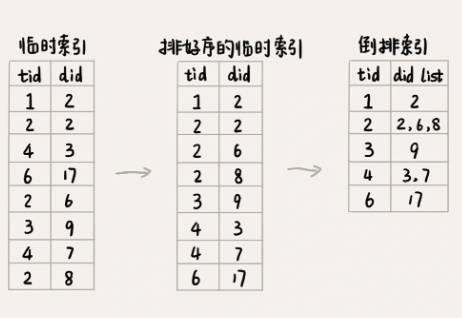
  
除了倒排文件之外，还需要一个文件，来记录每个单词编号在倒排索引文件中的偏移位置。把这个文件命名为 term_offset.bin。这个文件的作用是，帮助我们快速地查找某个单词编号在倒排索引中存储的位置，进而快速地从倒排索引中读取单词编号对应的网页编号列表。
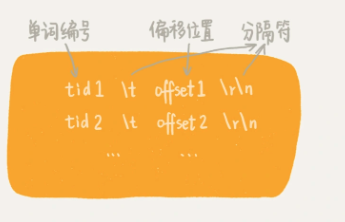


#### 查询

* doc_id.bin：记录网页链接和编号之间的对应关系。
* term_id.bin：记录单词和编号之间的对应关系。
* index.bin：倒排索引文件，记录每个单词编号以及对应包含它的网页编号列表
* term_offsert.bin：记录每个单词编号在倒排索引文件中的偏移位置。

实现一个小型的搜索引擎：
1. 这四个文件中，除了倒排索引文件（index.bin）比较大之外，其他的都比较小。为了方便快速查找数据，将其他三个文件都加载到内存中，并且组织成散列表这种数据结构。
2. 当用户在搜索框中，输入某个查询文本的时候，我们先对用户输入的文本进行分词处理。假设分词之后，我们得到 k 个单词。
3. 我们拿这 k 个单词，去 term_id.bin 对应的散列表中，查找对应的单词编号。经过这个查询之后，我们得到了这 k 个单词对应的单词编号。
4. 我们拿这 k 个单词编号，去 term_offset.bin 对应的散列表中，查找每个单词编号在倒排索引文件中的偏移位置。经过这个查询之后，我们得到了 k 个偏移位置。
5. 我们拿这 k 个偏移位置，去倒排索引（index.bin）中，查找 k 个单词对应的包含它的网页编号列表。经过这一步查询之后，我们得到了 k 个网页编号列表。
6. 我们针对这 k 个网页编号列表，统计每个网页编号出现的次数。具体到实现层面，我们可以借助散列表来进行统计。统计得到的结果，我们按照出现次数的多少，从小到大排序。出现次数越多，说明包含越多的用户查询单词（用户输入的搜索文本，经过分词之后的单词）。
7. 经过这一系列查询，我们就得到了一组排好序的网页编号。我们拿着网页编号，去 doc_id.bin 文件中查找对应的网页链接，分页显示给用户就可以了。

#### 补充

计算网页权重的[PageRank](https://zh.wikipedia.org/wiki/PageRank)算法、计算查询结果排名的 [tf-idf](https://zh.wikipedia.org/wiki/Tf-idf)模型等等。